# Run inference
Ref: http://trillium.tech/ml4floods/content/ml4ops/HOWTO_Run_Inference_on_new_data.html

In [1]:
import sys, os
from pathlib import Path
import importlib
from models import flooding_model

## Step 1: Get config

In [2]:
from ml4floods.models.config_setup import get_default_config

experiment_name = "WFV1_unet"
prod_dev = "2_PROD"

# config_fp = "train_models/training_flooding/config_rgbnir.json"
config_fp = "train_models/training_flooding_bgri/config_rgbnir_worldflood_model_2_epoch_40.json"

config = get_default_config(config_fp)
config.data_params.data_params='ml4cc_data_lake'

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory contrained environment set this value to 128
# config["model_params"]["max_tile_size"] = 128

Loaded Config for experiment:  training_flooding_bgri
{   'data_params': {   'batch_size': 48,
                       'bucket_id': '',
                       'channel_configuration': 'bgri',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_0',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/mnt/d/Flooding/train_test_split_local.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]},

## Step 2: Load pre-trained model

In [3]:
from pytorch_lightning.utilities.cloud_io import load
from models.flooding_model import WorldFloodsModel
importlib.reload(flooding_model)

model = WorldFloodsModel(config.model_params)
# path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnir.pt").replace("\\","/")
path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnir_worldflood_model_2_epoch_40.pt").replace("\\","/")

print(path_to_models)
model.load_state_dict(load(path_to_models))
model

model.eval()
model.to("cuda") # comment this line if your machine does not have GPU

num of channels:  4 , num of classes:  3
train_models/training_flooding_bgri/model_rgbnir_worldflood_model_2_epoch_40.pt


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), p

In [4]:
# from ml4floods.models.model_setup import get_model_inference_function
from models.inference import get_model_inference_function

inference_function = get_model_inference_function(model, config, apply_normalization=True)

Getting model inference function
Max tile size: 256


## Step 3: Helper functions for plotting and reading some demo data

In [5]:
import rasterio
import numpy as np
from rasterio import plot as rasterioplt
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

from typing import Optional, Tuple, Union

import torch
from ml4floods.data.worldfloods.configs import BANDS_S2, CHANNELS_CONFIGURATIONS
from ml4floods.visualization.plot_utils import download_tiff
import os
    

@torch.no_grad()
def read_inference_pair(tiff_inputs:str, folder_ground_truth:str, 
                        window:Optional[Union[rasterio.windows.Window, Tuple[slice,slice]]], 
                        return_ground_truth: bool=False, channels:bool=None, 
                        folder_permanent_water:Optional[str]=None,
                        cache_folder:Optional[str]=None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, rasterio.Affine]:
    """
    Read a pair of layers from the worldfloods bucket and return them as Tensors to pass to a model, return the transform for plotting with lat/long
    
    Args:
        tiff_inputs: filename for layer in worldfloods bucket
        folder_ground_truth: folder name to be replaced by S2 in the input
        window: window of layer to use
        return_ground_truth: flag to indicate if paired gt layer should be returned
        channels: list of channels to read from the image
        folder_permanent_water: Folder with permanent water layer raster.
        cache_folder: if provided and tiff_inputs are in a google bucket it will download the tiffs before opening them.
    
    Returns:
        (torch_inputs, torch_targets, transform): inputs Tensor, gt Tensor, transform for plotting with lat/long
    """
    
    if cache_folder is not None and tiff_inputs.startswith("gs"):
        tiff_inputs = download_tiff(cache_folder, tiff_inputs, folder_ground_truth, folder_permanent_water)
    
    tiff_targets = tiff_inputs.replace("/S2/", folder_ground_truth)

    with rasterio.open(tiff_inputs, "r") as rst:
        inputs = rst.read((np.array(channels) + 1).tolist(), window=window)
        # Shifted transform based on the given window (used for plotting)
        transform = rst.transform if window is None else rasterio.windows.transform(window, rst.transform)
        torch_inputs = torch.Tensor(inputs.astype(np.float32)).unsqueeze(0)
    
    if folder_permanent_water is not None:
        tiff_permanent_water = tiff_inputs.replace("/S2/", folder_permanent_water)
        with rasterio.open(tiff_permanent_water, "r") as rst:
            permanent_water = rst.read(1, window=window)  
            torch_permanent_water = torch.tensor(permanent_water)
    else:
        torch_permanent_water = torch.zeros_like(torch_inputs)
        
    if return_ground_truth:
        with rasterio.open(tiff_targets, "r") as rst:
            targets = rst.read(1, window=window)
        
        torch_targets = torch.tensor(targets).unsqueeze(0)
    else:
        torch_targets = torch.zeros_like(torch_inputs)
    
    return torch_inputs, torch_targets, torch_permanent_water, transform

COLORS_WORLDFLOODS = np.array([[0, 0, 0], # invalid
                               [139, 64, 0], # land
                               [0, 0, 139], # water
                               [220, 220, 220]], # cloud
                              dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS = ["invalid", "land", "water", "cloud"]

COLORS_WORLDFLOODS_PERMANENT = np.array([[0, 0, 0], # 0: invalid
                                         [139, 64, 0], # 1: land
                                         [237, 0, 0], # 2: flood_water
                                         [220, 220, 220], # 3: cloud
                                         [0, 0, 139], # 4: permanent_water
                                         [60, 85, 92]], # 5: seasonal_water
                                        dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS_PERMANENT = ["invalid", "land", "flood water", "cloud", "permanent water", "seasonal water"]

def gt_with_permanent_water(gt: np.ndarray, permanent_water: np.ndarray)->np.ndarray:
    """ Permanent water taken from: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_2_YearlyHistory"""
    gt[(gt == 2) & (permanent_water == 3)] = 4 # set as permanent_water
    gt[(gt == 2) & (permanent_water == 2)] = 5 # set as seasonal water
        
    return gt
            

def get_cmap_norm_colors(color_array, interpretation_array):
    cmap_categorical = colors.ListedColormap(color_array)
    norm_categorical = colors.Normalize(vmin=-.5,
                                        vmax=color_array.shape[0]-.5)
    patches = []
    for c, interp in zip(color_array, interpretation_array):
        patches.append(mpatches.Patch(color=c, label=interp))
    
    return cmap_categorical, norm_categorical, patches


def plot_inference_set(inputs: torch.Tensor, targets: torch.Tensor, 
                       predictions: torch.Tensor, permanent_water: torch.Tensor, transform: rasterio.Affine, 
                       channel_configuration:str)->None:
    """
    Plots inputs, targets and prediction into lat/long visualisation
    
    Args:
        inputs: input Tensor
        targets: gt target Tensor
        prediction: predictions output by model (softmax, argmax already applied)
        permanent_water: permanent water raster
        transform: transform used to plot with lat/long
    """
    fig, ax = plt.subplots(2,2,figsize=(16,16))
    
    inputs_show = inputs.cpu().numpy().squeeze()
    targets_show = targets.cpu().numpy().squeeze()
    permanent_water_show = permanent_water.numpy().squeeze()
    
    targets_show = gt_with_permanent_water(targets_show, permanent_water_show)
    
    
    # Color categories {-1: invalid, 0: land, 1: water, 2: clouds}
    
    cmap_preds, norm_preds, patches_preds = get_cmap_norm_colors(COLORS_WORLDFLOODS, INTERPRETATION_WORLDFLOODS)
    cmap_gt, norm_gt, patches_gt = get_cmap_norm_colors(COLORS_WORLDFLOODS_PERMANENT, INTERPRETATION_WORLDFLOODS_PERMANENT)
    
    # +1 because value 0 is invalid
    prediction_show = (predictions + 1).cpu().numpy().astype(float)
    
    band_names_current_image = [BANDS_S2[iband] for iband in CHANNELS_CONFIGURATIONS[channel_configuration]]
    
    if all(b in band_names_current_image for b in ["B4", "B3", "B2"]):
        bands = [band_names_current_image.index(b) for b in ["B4", "B3", "B2"]]
        rgb = np.clip(inputs_show[bands, :, :]/3000.,0,1)
        rasterioplt.show(rgb,transform=transform,ax=ax[0,0])
        ax[0,0].set_title("RGB Composite")
    else:
        print("Can't show RGB Composite image lacks bands")
    
    if all(b in band_names_current_image for b in ["B11", "B8", "B4"]):
        bands_false_composite = [BANDS_S2.index(b) for b in ["B11", "B8", "B4"]] # swir_1, nir, red composite
        false_rgb = np.clip(inputs_show[bands_false_composite, :, :]/3000.,0,1)
        rasterioplt.show(false_rgb,transform=transform,ax=ax[0,1])
        ax[0,1].set_title("SWIR1,NIR,R Composite")
    else:
        print("Can't show SWIR1,NIR,R Composite image lacks bands")
        
    rasterioplt.show(targets_show,transform=transform,ax=ax[1,0], cmap=cmap_gt, norm=norm_gt,
                     interpolation='nearest')
    rasterioplt.show(prediction_show, transform=transform, ax=ax[1,1],cmap=cmap_preds, norm=norm_preds,
                     interpolation='nearest')
    
    ax[1,0].set_title("Ground Truth")
    ax[1,0].legend(handles=patches_gt,
                 loc='upper right')
    
    ax[1,1].set_title("Model prediction")
    ax[1,1].legend(handles=patches_preds,
                   loc='upper right')
        

## Perform Inference using the `inference_function`

The `inference_function` let us run the model on large tiles. For doing this it follows the tiling and stiching strategy
described in https://arxiv.org/abs/1805.12219.

Can't show SWIR1,NIR,R Composite image lacks bands


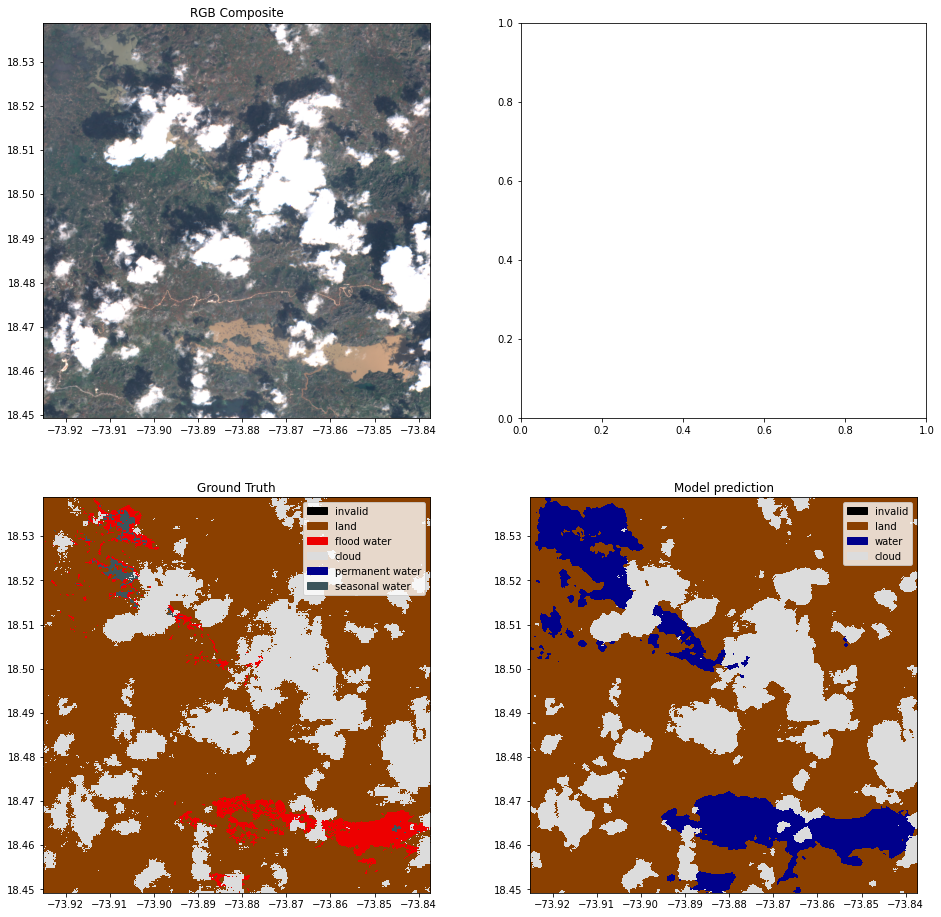

In [6]:
# from ml4floods.models.model_setup import get_channel_configuration_bands
from models.inference import get_channel_configuration_bands
import os


cache_folder = "/mnt/d/Flooding/worldfloods_v1_0/tiffs_for_inference"
os.makedirs(cache_folder, exist_ok=True)

channel_configuration = config.model_params.hyperparameters.channel_configuration
# tiff_s2, window, channels = "gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v1_0/val/S2/RS2_20161008_Water_Extent_Corail_Pestel.tif", None, get_channel_configuration_bands(channel_configuration)
tiff_s2, window, channels = "gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/val/S2/RS2_20161008_Water_Extent_Corail_Pestel.tif", None, get_channel_configuration_bands(channel_configuration)

# Load the image and ground truth
torch_inputs, torch_targets, \
   torch_permanent_water, transform = read_inference_pair(tiff_s2,folder_ground_truth="/gt/", 
                                                          window=window, return_ground_truth=True, channels=channels,
                                                          folder_permanent_water="/PERMANENTWATERJRC/",
                                                          cache_folder=cache_folder)

# Compute the prediction
outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
prediction = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform, 
                   channel_configuration=channel_configuration)

### Bonus: vectorise the water masks and plot them

In the code bellow `data_out` is a `GeoDataFrame` object. You can save it as a shapefile with [`save_file`](https://geopandas.org/docs/user_guide/io.html).

(28, 2)

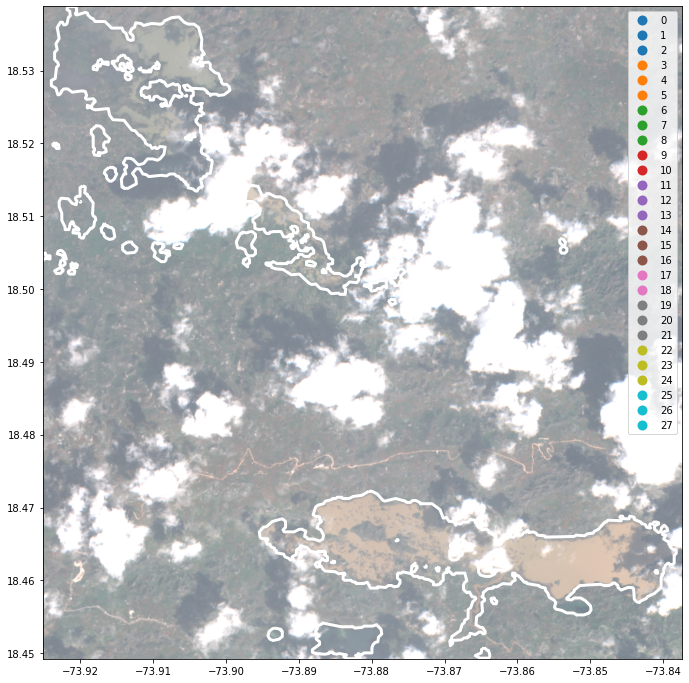

In [7]:
from ml4floods.models import postprocess
from ml4floods.visualization import plot_utils
import geopandas as gpd

prob_water_mask = outputs[0,1].cpu().numpy()
binary_water_mask = prob_water_mask>.5

geoms_polygons = postprocess.get_water_polygons(binary_water_mask, transform=transform)

data_out = gpd.GeoDataFrame({"geometry": geoms_polygons, "id": np.arange(len(geoms_polygons))})
fig, ax = plt.subplots(1,1, figsize=(12, 12))
data_out.plot("id",legend=True,categorical=True,ax=ax,facecolor="None",edgecolor="1",linewidth=3)
plot_utils.plot_s2_rbg_image(torch_inputs[0].cpu().numpy(), transform=transform, ax=ax, alpha=.6,
                             channel_configuration=channel_configuration)
data_out.shape

## Lets try another image!

Can't show SWIR1,NIR,R Composite image lacks bands


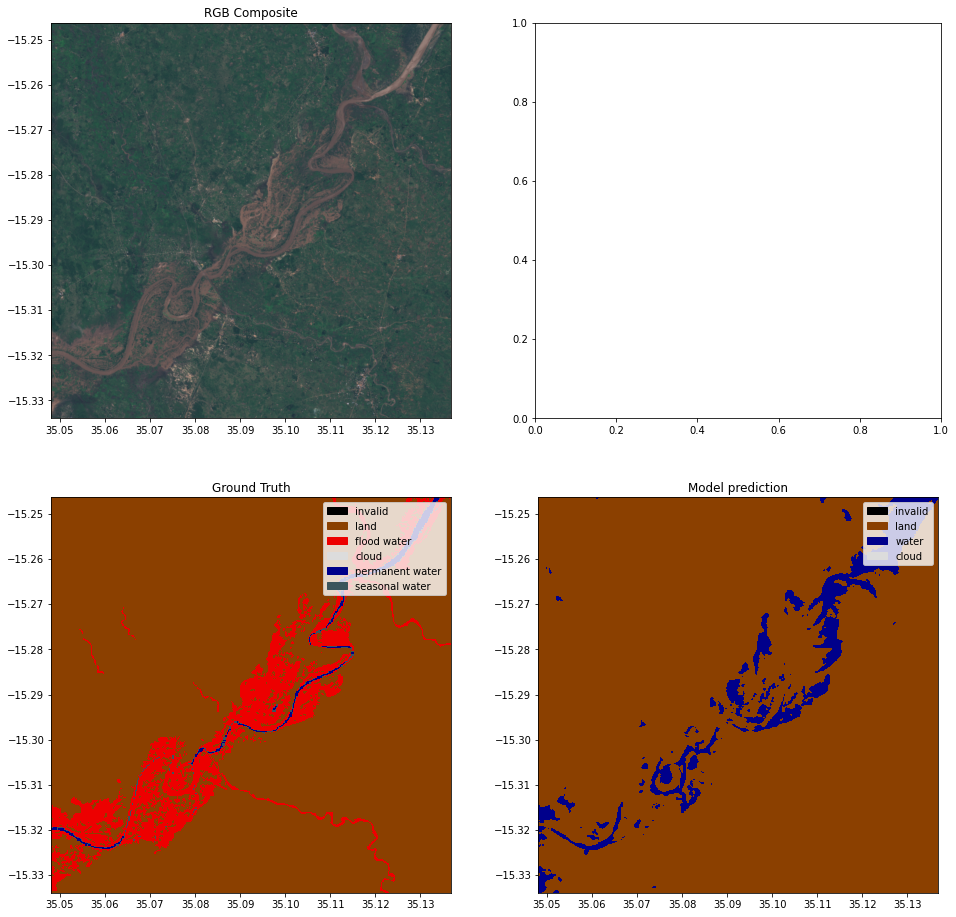

In [8]:
tiff_s2, window, channels = "gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/test/S2/EMSR347_07ZOMBA_DEL_v2_observed_event_a.tif", None, get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)

torch_inputs, torch_targets, torch_permanent_water, transform = read_inference_pair(tiff_s2, folder_ground_truth="/gt/", 
                                                                                    window=window, 
                                                                                    return_ground_truth=True, channels=channels,
                                                                                    folder_permanent_water="/PERMANENTWATERJRC/",
                                                                                    cache_folder=cache_folder)

outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
prediction = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform,channel_configuration=channel_configuration)

### Bonus: vectorise the water masks and plot them

(58, 2)

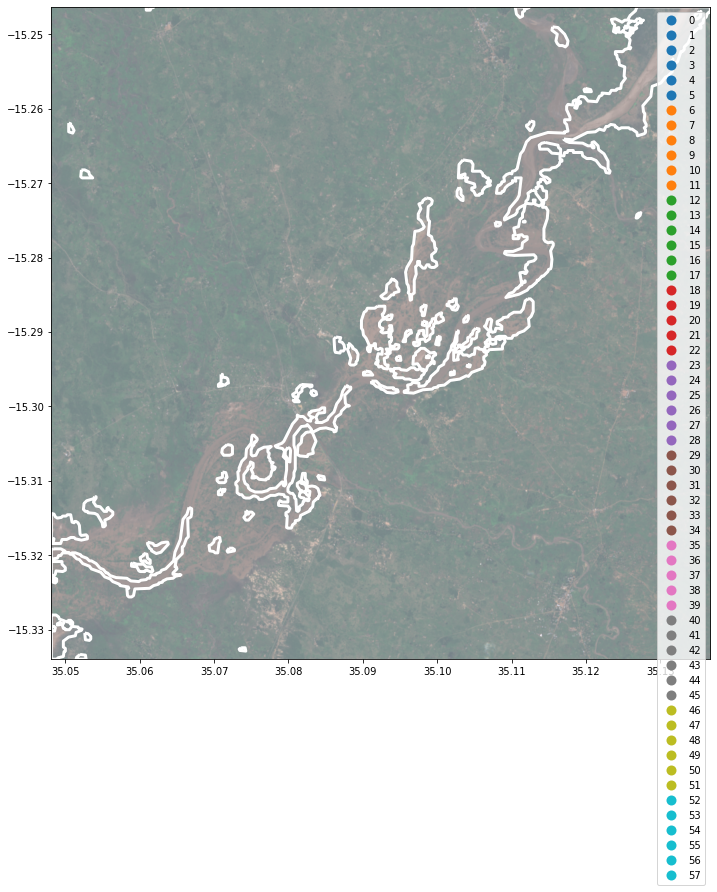

In [9]:
prob_water_mask = outputs[0,1].cpu().numpy()
binary_water_mask = prob_water_mask>.5

geoms_polygons = postprocess.get_water_polygons(binary_water_mask, transform=transform)

data_out = gpd.GeoDataFrame({"geometry": geoms_polygons, "id": np.arange(len(geoms_polygons))})
fig, ax = plt.subplots(1,1, figsize=(12, 12))
data_out.plot("id",legend=True,categorical=True,ax=ax,facecolor="None",edgecolor="1",linewidth=3)
plot_utils.plot_s2_rbg_image(torch_inputs[0].cpu().numpy(), transform=transform, ax=ax, alpha=.6,
                             channel_configuration=channel_configuration)
data_out.shape

## Lets try another image from the new data prepared by the Janitors!

Can't show SWIR1,NIR,R Composite image lacks bands


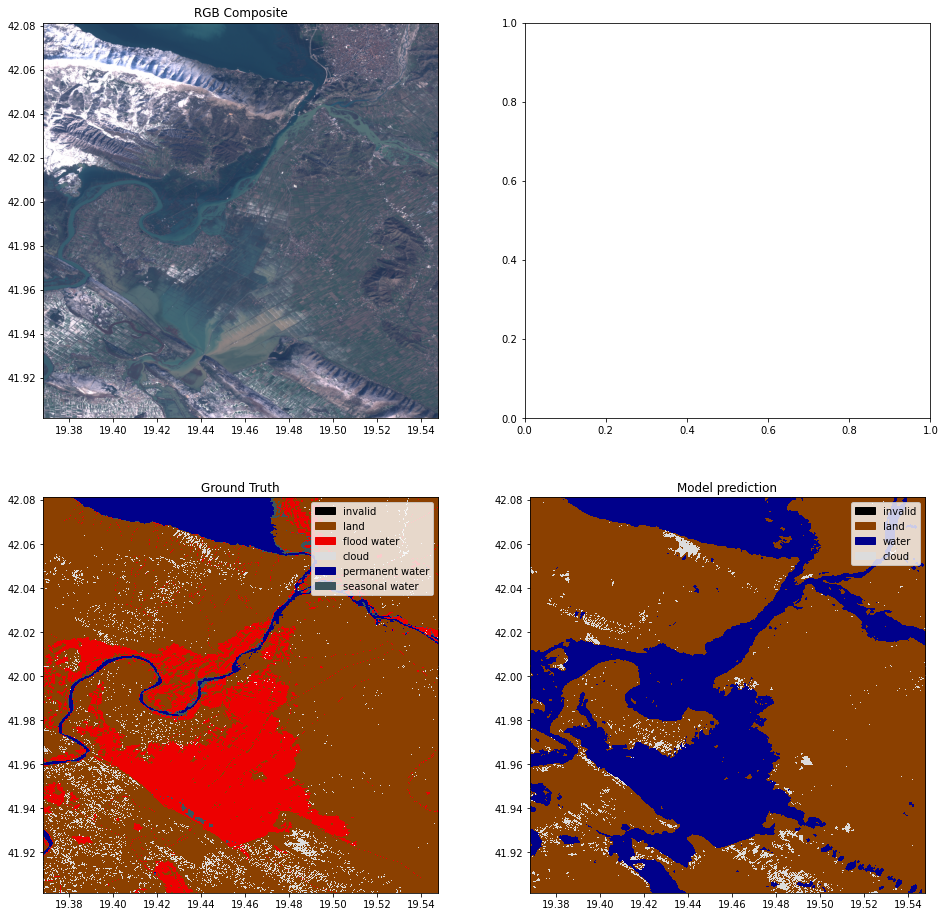

In [10]:
import rasterio.windows 
window = rasterio.windows.Window(col_off=1543, row_off=247, 
                                 width=2000, height=2000)
tiff_s2, channels = "gs://ml4cc_data_lake/2_PROD/1_Staging/WorldFloods/S2/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif", get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)

torch_inputs, torch_targets, torch_permanent_water, transform = read_inference_pair(tiff_s2, folder_ground_truth="/GT/V_1_1/", 
                                                                                    window=window, 
                                                                                    return_ground_truth=True, channels=channels,
                                                                                    folder_permanent_water="/JRC/",
                                                                                    cache_folder=cache_folder)

outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
prediction = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform,
                   channel_configuration=channel_configuration)

### Bonus: vectorise the water masks and plot them

(91, 2)

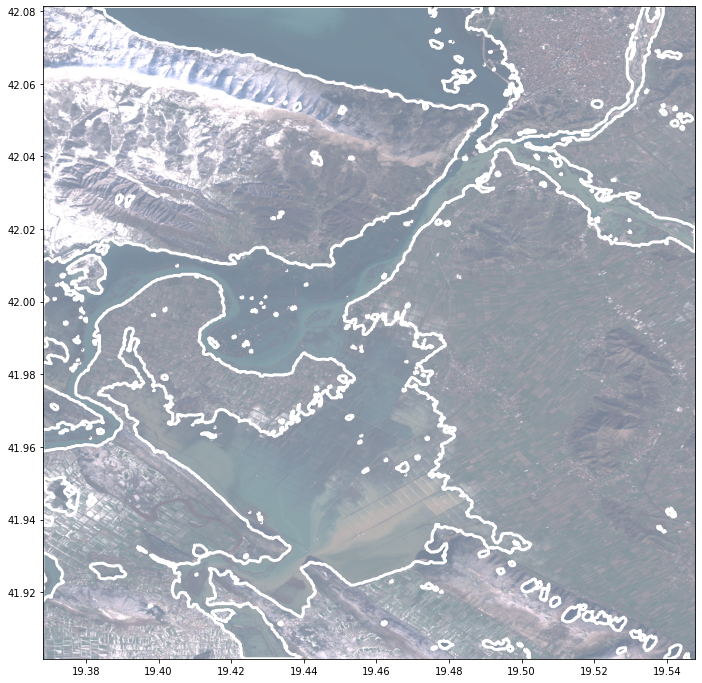

In [11]:
prob_water_mask = outputs[0,1].cpu().numpy()
binary_water_mask = prob_water_mask>.5

geoms_polygons = postprocess.get_water_polygons(binary_water_mask, transform=transform)

data_out = gpd.GeoDataFrame({"geometry": geoms_polygons, "id": np.arange(len(geoms_polygons))})
fig, ax = plt.subplots(1,1, figsize=(12, 12))
data_out.plot("id",legend=False,categorical=True,ax=ax,facecolor="None",edgecolor="1",linewidth=3)
plot_utils.plot_s2_rbg_image(torch_inputs[0].cpu().numpy(), transform=transform, ax=ax, alpha=.6,
                            channel_configuration=channel_configuration)
data_out.shape